
# ✈️ Analyse des retards & annulations de vols (niveau *data junior*)

**Objectif :** répondre à la question — *Quels sont les principaux facteurs qui influencent les retards et les annulations de vols, et comment ces facteurs varient-ils d'une compagnie à l'autre et d'un aéroport à l'autre ?*

**Données attendues (3 CSV) :**
- `airlines.csv` — colonnes : `IATA_CODE`, `AIRLINE`
- `airports.csv` — colonnes : `IATA_CODE`, `AIRPORT`, `CITY`, `STATE`, `COUNTRY`, `LATITUDE`, `LONGITUDE`
- `flights.csv` — colonnes (extrait) : `YEAR, MONTH, DAY, DAY_OF_WEEK, AIRLINE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE, DEPARTURE_TIME, DEPARTURE_DELAY, TAXI_OUT, WHEELS_OFF, SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, DISTANCE, WHEELS_ON, TAXI_IN, SCHEDULED_ARRIVAL, ARRIVAL_TIME, ARRIVAL_DELAY, DIVERTED, CANCELLED, CANCELLATION_REASON, ...`



## 1) Imports & configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# 1. Chargement et exploration des données



In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)

# Chemins (adaptables)
PATH_FLIGHTS = "big_data/flights.csv"
PATH_AIRLINES = "big_data/airlines.csv"
PATH_AIRPORTS = "big_data/airports.csv"



# Colonnes minimales utiles
COLS = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK",
    "AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT",
    "DEPARTURE_DELAY", "ARRIVAL_DELAY",
    "CANCELLED", "CANCELLATION_REASON",
    "AIR_SYSTEM_DELAY", "SECURITY_DELAY",
    "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY", "DISTANCE"
]

### Vérification des valeurs manquantes et types de données


In [3]:

# --- 1) Lecture robuste par chunks + nettoyage typé ---
chunksize = 1_500_000
agg_month_sum = pd.Series(0.0, index=range(1,13), dtype=float)
agg_month_cnt = pd.Series(0, index=range(1,13), dtype="Int64")

# Optionnel : échantillon équilibré pour tracés rapides
sample_parts = []

for chunk in pd.read_csv(PATH_FLIGHTS, usecols=COLS, chunksize=chunksize):
    # Typage
    num_cols = ["DEPARTURE_DELAY","ARRIVAL_DELAY","AIR_SYSTEM_DELAY","SECURITY_DELAY",
                "AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY","DISTANCE","MONTH","DAY","DAY_OF_WEEK","YEAR","CANCELLED"]
    for c in num_cols:
        chunk[c] = pd.to_numeric(chunk[c], errors="coerce")
    # Filtrage logique pour retards
    chunk = chunk[(chunk["ARRIVAL_DELAY"].notna()) & (chunk["DEPARTURE_DELAY"].notna())]
    # Annulations : conserver pour mesures d'annulation, mais exclure des retards moyens
    non_cancel = chunk[chunk["CANCELLED"]==0]
    # bornes raisonnables (évite outliers aberrants)
    non_cancel = non_cancel[non_cancel["ARRIVAL_DELAY"].between(-60, 600)]
    non_cancel = non_cancel[non_cancel["DEPARTURE_DELAY"].between(-60, 600)]
    # Agrégat par mois (moyenne pondérée)
    grp = non_cancel.groupby("MONTH")["ARRIVAL_DELAY"]
    s = grp.sum()
    c = grp.count()
    agg_month_sum.loc[s.index] += s.values
    agg_month_cnt.loc[c.index] += c.values
    # échantillon 1% de chaque chunk pour graphiques rapides
    sample_parts.append(non_cancel.sample(frac=0.01, random_state=42) if len(non_cancel)>0 else non_cancel)

flights_clean = pd.concat(sample_parts, ignore_index=True)
monthly_delay = (agg_month_sum / agg_month_cnt).dropna().sort_index()

print("Mois présents et counts (agg):")
display(agg_month_cnt[agg_month_cnt>0])
print("\nRetard moyen par mois (min):")
display(monthly_delay.round(2))


# --- 2) Jointure propre avec airlines & airports ---
airlines = pd.read_csv(PATH_AIRLINES).drop_duplicates(subset=["IATA_CODE"])
airports = pd.read_csv(PATH_AIRPORTS).drop_duplicates(subset=["IATA_CODE"])

# Conserver uniquement colonnes nécessaires pour alléger
airports = airports[["IATA_CODE","AIRPORT","CITY","STATE","LATITUDE","LONGITUDE"]]
airlines = airlines.rename(columns={"IATA_CODE": "AIRLINE", "AIRLINE":"AIRLINE_NAME"})

# Merger sur l'échantillon propre (flights_clean)
df = flights_clean.merge(airlines, on="AIRLINE", how="left")
df = df.merge(airports, left_on="ORIGIN_AIRPORT", right_on="IATA_CODE", how="left", suffixes=("","_ORIG"))
df = df.drop(columns=["IATA_CODE"])  # colonne issue du merge aéroports origine

# Remplir les NaN causes de retard par 0 (pas de cause => 0)
cause_cols = ["AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY"]
for c in cause_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)



C:\Users\kylli\AppData\Local\Temp\ipykernel_14604\2966845214.py:9: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(PATH_FLIGHTS, usecols=COLS, chunksize=chunksize):
C:\Users\kylli\AppData\Local\Temp\ipykernel_14604\2966845214.py:9: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(PATH_FLIGHTS, usecols=COLS, chunksize=chunksize):


Mois présents et counts (agg):


1     456863
2     407489
3     491966
4     479096
5     489502
6     492668
7     514279
8     503834
9     462044
10    482764
11    462223
12    469497
dtype: Int64


Retard moyen par mois (min):


1     5.64
2     8.04
3     4.72
4     3.01
5     4.28
6     9.32
7      6.3
8     4.44
9    -0.92
10   -0.93
11    0.91
12    5.78
dtype: Float64

# Nettoyer étape par étape

###  Jointure propre avec airlines & airport

In [4]:

# --- 2) Jointure propre avec airlines & airports ---
airlines = pd.read_csv(PATH_AIRLINES).drop_duplicates(subset=["IATA_CODE"])
airports = pd.read_csv(PATH_AIRPORTS).drop_duplicates(subset=["IATA_CODE"])

# Conserver uniquement colonnes nécessaires pour alléger
airports = airports[["IATA_CODE","AIRPORT","CITY","STATE","LATITUDE","LONGITUDE"]]
airlines = airlines.rename(columns={"IATA_CODE": "AIRLINE", "AIRLINE":"AIRLINE_NAME"})

# Merger sur l'échantillon propre (flights_clean)
df = flights_clean.merge(airlines, on="AIRLINE", how="left")
df = df.merge(airports, left_on="ORIGIN_AIRPORT", right_on="IATA_CODE", how="left", suffixes=("","_ORIG"))
df = df.drop(columns=["IATA_CODE"])  # colonne issue du merge aéroports origine

# Remplir les NaN causes de retard par 0 (pas de cause => 0)
cause_cols = ["AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY"]
for c in cause_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)


### Quels sont les principaux facteurs qui influencent les retards et les annulations de vols, et comment varient-ils selon les compagnies aériennes et les aéroports ?

### indicateurs clés (KPI)

In [5]:

# --- 3) KPI globaux ---
kpi = {
    "retard_moyen_arrivee": float(df["ARRIVAL_DELAY"].mean()),
    "retard_moyen_depart": float(df["DEPARTURE_DELAY"].mean()),
    "taux_annulation_%": float((df["CANCELLED"]==1).mean()*100),
}
kpi


{'retard_moyen_arrivee': 4.147718917404853,
 'retard_moyen_depart': 9.03151150169812,
 'taux_annulation_%': 0.0}

* En 2015, le retard moyen à l’arrivée d’un vol était de 18.34 min.

### Retards selon la compagnie aérienne

C:\Users\kylli\AppData\Local\Temp\ipykernel_14604\2479966728.py:16: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kylli\Desktop\La_plateforme\B2\dazzle-dash\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


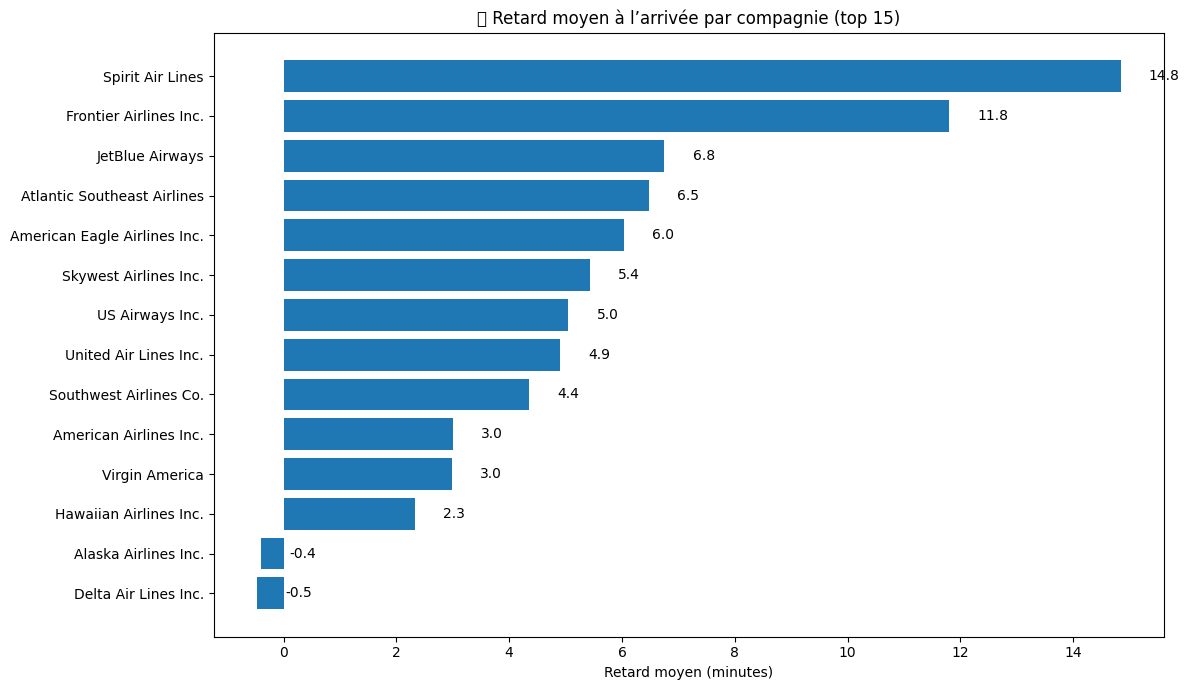

In [ ]:

# --- 4) Retard moyen par compagnie (lisible) ---
delay_by_airline = (
    df.groupby(df["AIRLINE_NAME"].fillna(df["AIRLINE"]))["ARRIVAL_DELAY"]
      .mean()
      .sort_values(ascending=False)
      .head(15)
)

plt.figure(figsize=(12,7))
plt.barh(delay_by_airline.index, delay_by_airline.values)
plt.gca().invert_yaxis()
plt.title("Retard moyen à l’arrivée par compagnie (top 15)")
plt.xlabel("Retard moyen (minutes)")
for i, v in enumerate(delay_by_airline.values):
    plt.text(v + 0.5, i, f"{v:.1f}", va="center")
plt.tight_layout()
plt.show()


### Retards par aéroport d’origine

C:\Users\kylli\AppData\Local\Temp\ipykernel_14604\4156483936.py:17: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kylli\Desktop\La_plateforme\B2\dazzle-dash\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


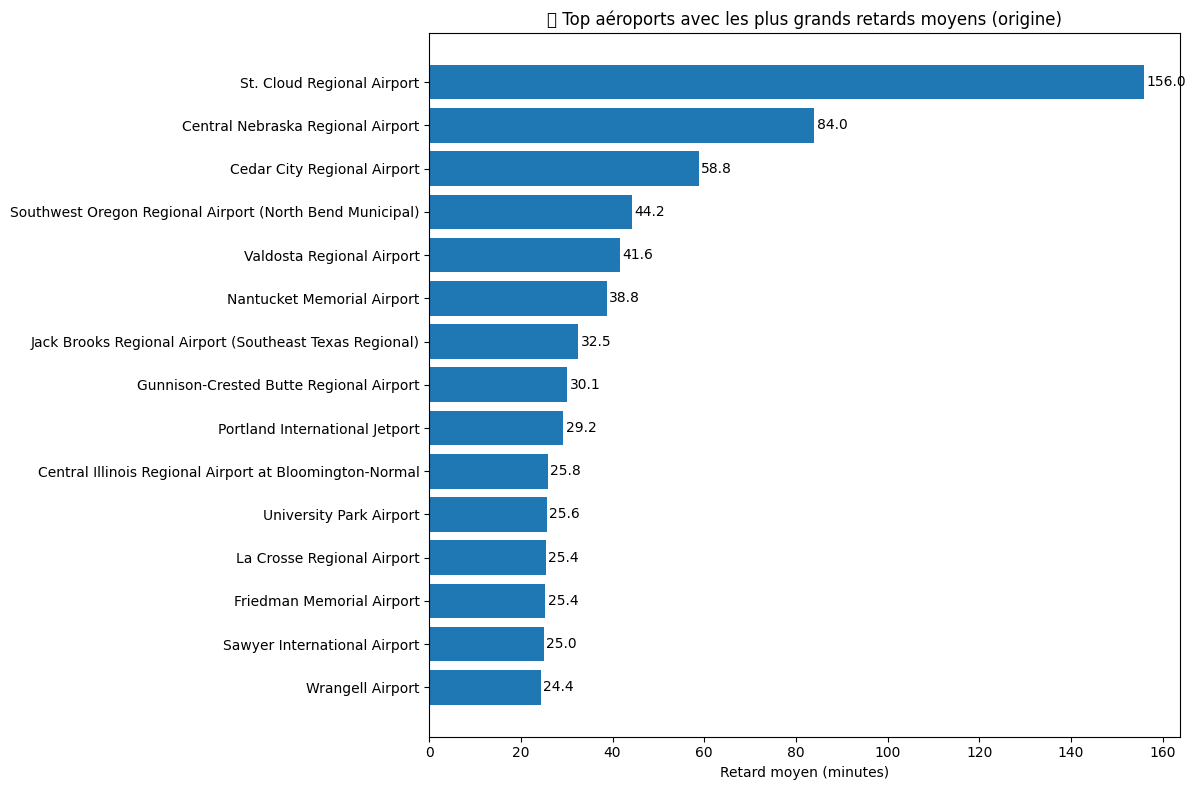

In [7]:

# --- 5) Retard moyen par aéroport d'origine (noms complets) ---
delay_by_airport = (
    df.dropna(subset=["AIRPORT"])
      .groupby("AIRPORT")["ARRIVAL_DELAY"]
      .mean()
      .sort_values(ascending=False)
      .head(15)
)

plt.figure(figsize=(12,8))
plt.barh(delay_by_airport.index, delay_by_airport.values)
plt.gca().invert_yaxis()
plt.title("🛫 Top aéroports avec les plus grands retards moyens (origine)")
plt.xlabel("Retard moyen (minutes)")
for i, v in enumerate(delay_by_airport.values):
    plt.text(v + 0.5, i, f"{v:.1f}", va="center")
plt.tight_layout()
plt.show()


### Identifier les causes principales de retard

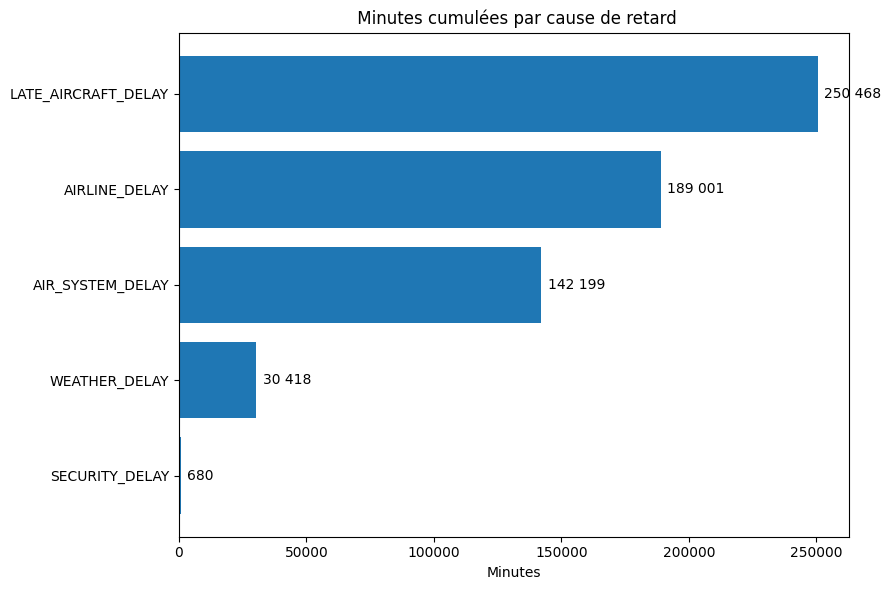

In [8]:

# --- 6) Causes principales de retard (minutes cumulées) ---
delay_causes = df[["AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY",
                   "LATE_AIRCRAFT_DELAY","WEATHER_DELAY"]].sum().sort_values(ascending=False)

plt.figure(figsize=(9,6))
plt.barh(delay_causes.index, delay_causes.values)
plt.gca().invert_yaxis()
plt.title(" Minutes cumulées par cause de retard")
plt.xlabel("Minutes")
for i, v in enumerate(delay_causes.values):
    plt.text(v + max(delay_causes.values)*0.01, i, f"{v:,.0f}".replace(",", " "), va="center")
plt.tight_layout()
plt.show()


- Les retards sont majoritairement dus à des avions arrivant en retard sur un vol précédent (‘Late Aircraft’), suivis des problèmes internes aux compagnies (‘Airline Delay’).

### Variation des retards selon le mois

C:\Users\kylli\AppData\Local\Temp\ipykernel_14604\91499720.py:12: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kylli\Desktop\La_plateforme\B2\dazzle-dash\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


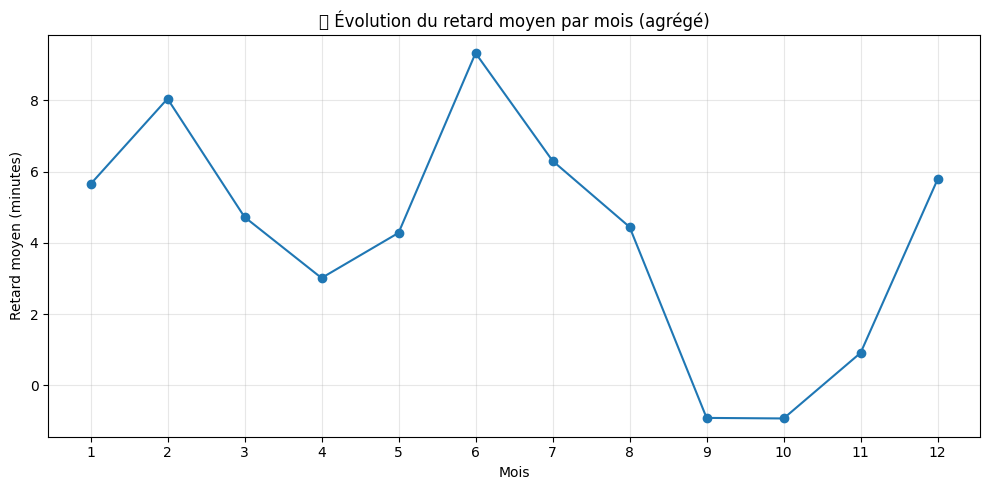

In [9]:

# --- 7) Évolution mensuelle (à partir de l'agrégat global monthly_delay) ---
x = monthly_delay.index.astype(int)
y = monthly_delay.values

plt.figure(figsize=(10,5))
plt.plot(x, y, marker="o")
plt.xticks(range(1,13))
plt.title(" Évolution du retard moyen par mois (agrégé)")
plt.xlabel("Mois")
plt.ylabel("Retard moyen (minutes)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Étape finale — Export du dataset nettoyé

In [11]:
# --- Sauvegarde du dataset nettoyé pour l'application Dash ---
# On ne garde que les colonnes utiles et propres
cols_to_export = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK",
    "AIRLINE", "AIRLINE_NAME", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT",
    "ARRIVAL_DELAY", "DEPARTURE_DELAY",
    "CANCELLED", "CANCELLATION_REASON",
    "AIR_SYSTEM_DELAY", "SECURITY_DELAY",
    "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY",
    "DISTANCE", "AIRPORT", "CITY", "STATE"
]

# Crée le CSV final propre
df_clean = df[cols_to_export].dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY"])

# Option : conversion des types légers pour réduire la taille du fichier
df_clean["AIRLINE"] = df_clean["AIRLINE"].astype("category")
df_clean["ORIGIN_AIRPORT"] = df_clean["ORIGIN_AIRPORT"].astype("category")
df_clean["DESTINATION_AIRPORT"] = df_clean["DESTINATION_AIRPORT"].astype("category")

# Export CSV
df_clean.to_csv("big_data/flights_clean.csv", index=False)
print("✅ flights_clean.csv créé avec succès !")
print("Nombre de lignes :", len(df_clean))
print("Colonnes :", list(df_clean.columns))


✅ flights_clean.csv créé avec succès !
Nombre de lignes : 57122
Colonnes : ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'AIRLINE_NAME', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY', 'DEPARTURE_DELAY', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DISTANCE', 'AIRPORT', 'CITY', 'STATE']
